In [617]:
import pandas as pd 
import numpy as np 
from scipy import stats
from scipy.stats import chi2
from scipy.stats import *
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 5]

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format


# Part 1 
## 1)Importing data files

In [618]:
airport_codes=pd.read_csv('/Users/shikharbajpai/Downloads/data 2/Airport_Codes.csv')
flights=pd.read_csv('/Users/shikharbajpai/Downloads/data 2/flights.csv')
tickets=pd.read_csv('/Users/shikharbajpai/Downloads/data 2/tickets.csv')


In [619]:
airport_codes=airport_codes[((airport_codes['TYPE']=='medium_airport') | (airport_codes['TYPE']=='large_airport')) & (airport_codes['ISO_COUNTRY']=='US') ]
tickets=tickets[tickets['ROUNDTRIP']==1]
flights=flights[flights['CANCELLED']==0]
#tickets['ITIN_FARE']=tickets['ITIN_FARE'].astype('float')



## 3) Finding Duplicates and deleting them

There are duplicates in all the table so deleting them.

In [620]:
print (len(airport_codes))
print (len(airport_codes.drop_duplicates()))
print (len(flights))
print (len(flights)-len(flights.drop_duplicates()))
print (len(tickets))
print (len(tickets)-len(tickets.drop_duplicates()))
airport_codes=airport_codes.drop_duplicates()
flights=flights.drop_duplicates()
tickets=tickets.drop_duplicates()



858
858
1864272
4410
708600
47564


## 2) Removing unnecessary Columns from datafiles

In [621]:
## Removing Unneccesary columns from each tables
airport_codes=airport_codes.drop(['NAME','CONTINENT','ISO_COUNTRY','MUNICIPALITY','COORDINATES','ELEVATION_FT'],axis=1)
tickets=tickets.drop(['ITIN_ID','YEAR','QUARTER','ORIGIN_COUNTRY','ORIGIN_STATE_ABR','ROUNDTRIP'],axis=1)
flights=flights.drop(['FL_DATE','OP_CARRIER_FL_NUM','TAIL_NUM','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'],axis=1)


In [622]:
print(tickets.info())
print(airport_codes.info())
print(flights.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 661036 entries, 0 to 1115067
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ORIGIN             661036 non-null  object 
 1   ORIGIN_STATE_NM    661036 non-null  object 
 2   REPORTING_CARRIER  661036 non-null  object 
 3   PASSENGERS         660076 non-null  float64
 4   ITIN_FARE          660585 non-null  object 
 5   DESTINATION        661036 non-null  object 
dtypes: float64(1), object(5)
memory usage: 35.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 6194 to 50008
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TYPE       858 non-null    object
 1   IATA_CODE  821 non-null    object
dtypes: object(2)
memory usage: 20.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1859862 entries, 0 to 1911340
Data columns (total 11 columns):
 #   Column    

## 3) Type casting some columns with object values to integer or float
### Discrepencies in data found 
1) Numbers have sometimes dollar symbol attached to it. Removing the dollar sign
2) DISTANCE AND AIR_TIME have sometime alphabatical values. So removing them and putting those values to null

In [623]:
tickets = tickets.assign(ITIN_FARE = lambda x: x['ITIN_FARE'].str.extract('(\d+)'))
flights = flights.assign(AIR_TIME = lambda x: x['AIR_TIME'].str.extract('(\d+)'))
flights = flights.assign(DISTANCE = lambda x: x['DISTANCE'].str.extract('(\d+)'))


For flights distance, it irrelavant that they have hundred miles or twenty miles values so putting these values to null. Later on we would impute these null values

In [624]:
## Finally typecasting some object columns to float. 
flights['AIR_TIME']=flights['AIR_TIME'].astype(float)
flights['DISTANCE']=flights['DISTANCE'].astype(float)
tickets['ITIN_FARE']=tickets['ITIN_FARE'].astype(float)

## Remove negative values from DEP_DELAY and ARR_DELAY as they are later used in calculation
"""Negating 15 minutes from Dep_Delay and Arr_delay. In case substraction is negative replacing it with 0.This would be used in later 
 on calculations"""

flights['DEP_DELAY'].loc[flights['DEP_DELAY']<0]=0
flights['ARR_DELAY'].loc[flights['ARR_DELAY']<0]=0
flights['DEP_DELAY']=np.where((flights['DEP_DELAY']-15<0),0 , flights['DEP_DELAY']-15)
flights['ARR_DELAY']=np.where((flights['ARR_DELAY']-15<0),0 , flights['ARR_DELAY']-15)


"""Similarly multiplying occupancy_rate by 200 as all the flights are of 200 capicity. This would also be used in later on calculations"""
flights['OCCUPANCY_RATE']=flights["OCCUPANCY_RATE"]*200

## 4) Dealing with Outliers
### FLIGHTS DATA

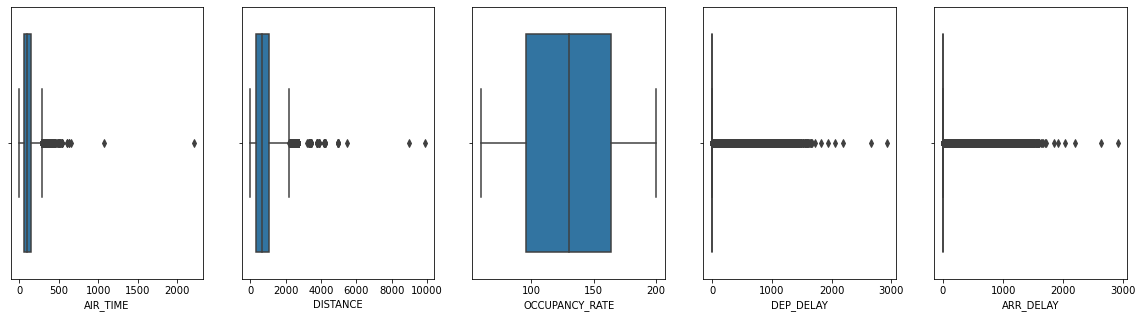

In [625]:


fig, ax =plt.subplots(1,5)
sns.boxplot(x='AIR_TIME',data=flights,ax=ax[0])
sns.boxplot(x='DISTANCE',data=flights,ax=ax[1])
sns.boxplot(x='OCCUPANCY_RATE',data=flights,ax=ax[2])
sns.boxplot(x='DEP_DELAY',data=flights,ax=ax[3])
sns.boxplot(x='ARR_DELAY',data=flights,ax=ax[4])


fig.show()

### TICKETS DATA

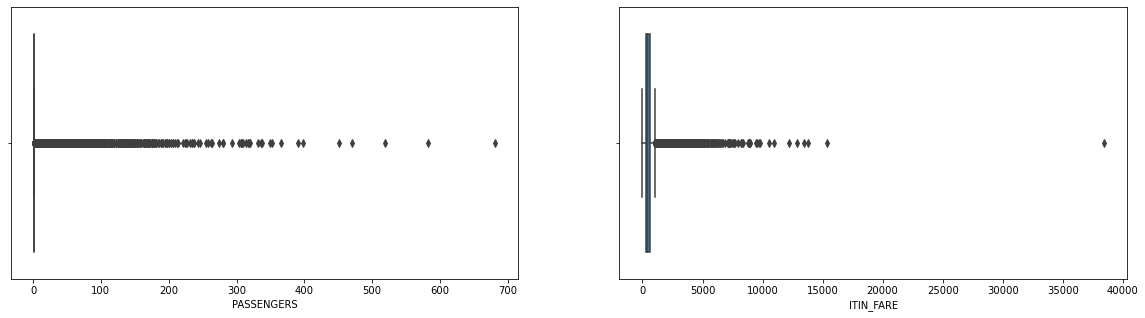

In [626]:
fig, ax =plt.subplots(1,2)
sns.boxplot(x='PASSENGERS',data=tickets,ax=ax[0])
sns.boxplot(x='ITIN_FARE',data=tickets,ax=ax[1])
fig.show()

### ANOMALIES

In [627]:
tickets[tickets['PASSENGERS']>300]

,ORIGIN,ORIGIN_STATE_NM,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
83429,ATL,Georgia,DL,365.00,11.00,MIA
150251,BOS,Massachusetts,B6,306.00,11.00,TPA
333958,DTW,Michigan,DL,681.00,11.00,MCO
336742,DTW,Michigan,DL,471.00,11.00,TPA
356723,EWR,New Jersey,UA,519.00,0.00,PBI
420890,HNL,Hawaii,HA,349.00,148.00,LIH
421466,HOU,Texas,WN,319.00,11.00,LAS
423080,HOU,Texas,WN,307.00,523.00,DAL
486851,JFK,New York,B6,304.00,11.00,MCO
496461,JFK,New York,B6,331.00,11.00,PBI


How it could be that the fare is so low.

In [628]:
tickets[tickets['ITIN_FARE']>10000]

,ORIGIN,ORIGIN_STATE_NM,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
36135,PIH,Idaho,OO,1.00,13790.00,SLC
110692,BDL,Connecticut,YV,1.00,12225.00,IAH
355172,EWR,New Jersey,UA,1.00,12882.00,ORD
527911,LAX,California,UA,1.00,10944.00,ORD
586574,MCI,Missouri,UA,1.00,10564.00,PHX
927914,SFO,California,UA,1.00,13474.00,LAS
929787,SFO,California,UA,1.00,15365.00,EWR
968736,SLC,Utah,OO,1.00,38400.00,TWF


Some ticket fares are too high. The last one which is 38400 seems unreasonable

## Dealing with Ouliers. 

By seeing various plots we could determine what values we want to consider as outliers and how do we want to replace them 


In [629]:
def replacing_outliers_with_median(df,col,value_min=False,value_max=False):
    if(value_max):
        df[col].loc[df[col]>value_max]=df[col].median()
    if(value_max):
        df[col].loc[df[col]<value_min]=df[col].median()
    else:
        raise ValueError('Both of the Valuse_min and Value_max not passed. One is compulsory')
        
    
    
    

### Conditions for Outliers that I assumed and put in values 

1)By Boxplot we see that AirTime above 200 is very high as we see on the boxplot and there was a value which was around 10. So removing them

2)Similar checks I did on Distance,Dep_delay,Arr_delayPassengers,Itin_fare.

Maybe these values are not actual outliers and true values but still we are making it as median so there won't be much deviation and will increase the accuracy of our analysis 

In [630]:

replacing_outliers_with_median(flights,'AIR_TIME',50,1000)
replacing_outliers_with_median(flights,'DISTANCE',50,6000)
replacing_outliers_with_median(flights,'DEP_DELAY',False,1750)
replacing_outliers_with_median(flights,'ARR_DELAY',False,2000)


replacing_outliers_with_median(tickets,'PASSENGERS',0,300)
replacing_outliers_with_median(tickets,'ITIN_FARE',20,15000)


## 4) Dealing with null values

The missing data for each dataframe is less than 1%. So will be filling the values with median as it is robust to outliers. It is seen that there are many outliers in our data and we could not confirm that if they are actual outliers. 

Other methods:
1) Using Random Forest method to fill in the missing values
2) Using grouby on different states and finding out medians. It is more robust than universal median

In [631]:
print (airport_codes.isnull().sum()* 100 / len(airport_codes))
## IATA_CODE missing we could remove those rows. As it is the basic necessity and nothing could be done for it. 

print (tickets.isnull().sum()* 100 / len(tickets))
## PASSENGERS and ITIN_FARE is missing. We will try to replace nulls with median as it is robust to outliers.

print (flights.isnull().sum()* 100 / len(flights))
##  ARR_DELAY , AIR_TIME,DISTANCE,OCCUPANCY_RATE. Replace with median

TYPE        0.00
IATA_CODE   4.31
dtype: float64
ORIGIN              0.00
ORIGIN_STATE_NM     0.00
REPORTING_CARRIER   0.00
PASSENGERS          0.15
ITIN_FARE           0.07
DESTINATION         0.00
dtype: float64
OP_CARRIER          0.00
ORIGIN              0.00
ORIGIN_CITY_NAME    0.00
DESTINATION         0.00
DEST_CITY_NAME      0.00
DEP_DELAY           0.00
ARR_DELAY           0.23
CANCELLED           0.00
AIR_TIME           99.45
DISTANCE           99.45
OCCUPANCY_RATE      0.00
dtype: float64


In [632]:
airport_codes=airport_codes.fillna(airport_codes.median())
tickets=tickets.fillna(tickets.median())
flights=flights.fillna(flights.median())


In [633]:
print (airport_codes.isnull().sum())
## IATA_CODE missing we could remove those rows. As it is the basic necessity and nothing could be done for it. 

print (tickets.isnull().sum())
## PASSENGERS and ITIN_FARE is missing. We will try to replace nulls with median as it is robust to outliers.

print (flights.isnull().sum())
##  ARR_DELAY , AIR_TIME,DISTANCE,OCCUPANCY_RATE. Replace with median

TYPE          0
IATA_CODE    37
dtype: int64
ORIGIN               0
ORIGIN_STATE_NM      0
REPORTING_CARRIER    0
PASSENGERS           0
ITIN_FARE            0
DESTINATION          0
dtype: int64
OP_CARRIER          0
ORIGIN              0
ORIGIN_CITY_NAME    0
DESTINATION         0
DEST_CITY_NAME      0
DEP_DELAY           0
ARR_DELAY           0
CANCELLED           0
AIR_TIME            0
DISTANCE            0
OCCUPANCY_RATE      0
dtype: int64


## 5) Merging of data files into a single file

 ### Rather than merging each individual ticket with flights and airport_codes we are grouping the tickets on the basis of origin, and destination and taking mean hence it will save us time and complexity.
 
 ### Similarty we will do the same thing with flights dataframe 
 
###  After these we would merge all the dataframes

In [655]:
tickets=tickets.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_STATE_NM':'first',
                                                   'PASSENGERS': np.sum,
                                                   'ITIN_FARE': np.sum}).reset_index()

## cancelled is not needed as we have filtered already for non-cancelled flights but still taking count as it could be used to find total number of fligts in the route
flights=flights.groupby(['ORIGIN','DESTINATION']).agg({'ORIGIN_CITY_NAME':'first',
                                                                        'DEST_CITY_NAME': 'first',
                                                                        'DEP_DELAY': np.sum,
                                                                        'ARR_DELAY': np.sum,
                                                                        'AIR_TIME': np.sum,
                                                                        'DISTANCE': np.sum,
                                                                        'OCCUPANCY_RATE':np.sum,
                                                                        'CANCELLED':'count'}).reset_index()

In [635]:

## merging all datasets 
final=tickets.merge(flights,on=['ORIGIN','DESTINATION'])
final=final.merge(airport_codes,left_on='ORIGIN',right_on='IATA_CODE',suffixes=('_left', '_right'))
final=final.merge(airport_codes,left_on='DESTINATION',right_on='IATA_CODE',suffixes=('_left', '_right'))
final.drop(columns={'IATA_CODE_left','IATA_CODE_right'},inplace=True)
final.rename(columns={'CANCELLED':'total_count'},inplace=True)
final['route']=final['ORIGIN_CITY_NAME']+' TO '+final['DEST_CITY_NAME']
data=final.copy()

## Question 1)
The 10 busiest round trip routes in terms of number of round trip flights in the quarter.Exclude canceled flights when performing the calculation.

In [636]:
temp=data.sort_values(by='OCCUPANCY_RATE',ascending=False)[:10]

[Text(0, 0, 'San Francisco, CA TO Los Angeles, CA'),
 Text(1, 0, 'Los Angeles, CA TO San Francisco, CA'),
 Text(2, 0, 'Chicago, IL TO New York, NY'),
 Text(3, 0, 'New York, NY TO Chicago, IL'),
 Text(4, 0, 'Los Angeles, CA TO Las Vegas, NV'),
 Text(5, 0, 'Las Vegas, NV TO Los Angeles, CA'),
 Text(6, 0, 'Los Angeles, CA TO New York, NY'),
 Text(7, 0, 'New York, NY TO Los Angeles, CA'),
 Text(8, 0, 'Los Angeles, CA TO Seattle, WA'),
 Text(9, 0, 'Seattle, WA TO Los Angeles, CA')]

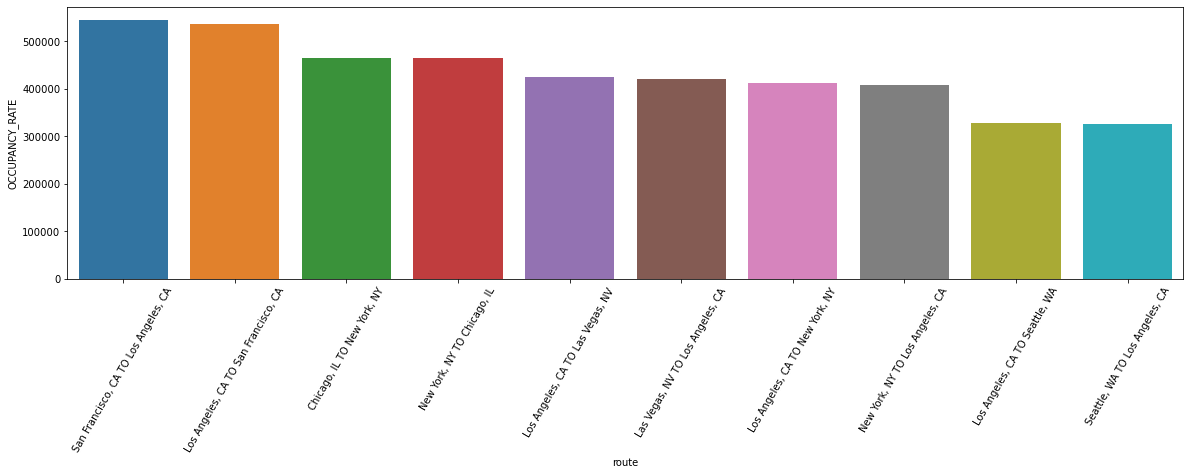

In [637]:
ax=sns.barplot(x=temp['route'],y=temp['OCCUPANCY_RATE'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


The question asked for 10 busiest round trips. So Even if the origin and destination are reversed. Still I am considering this route as a new one because we are doing round trips.

## Question 2) 
The 10 most profitable round trip routes (without considering the upfront airplane cost) in
the quarter. Along with the profit, show total revenue, total cost, summary values of
other key components and total round trip flights in the quarter for the top 10 most
profitable routes. Exclude canceled flights from these calculations.

Esimates given in the Challenge are as follows:

1) Fuel, Oil, Maintenance, Crew $8 per mile total

2) Depreciation, Insurance, Other $1.18 per mile total

3) Airport operational costs for the right to use the airports and related services are fixed at 5000 dollars for medium airports and 10,000 dollars for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of two airport charges.

4) For each individual departure, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs.

5) For each individual arrival, the first 15 minutes of delays are free, otherwise each minute costs the airline $75 in added operational costs

6) Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set. Do not use the Tickets data set to determine occupancy.

7) Baggage fee is 35 dollars for each checked bag per flight. We expect 50% of passengers to check an average of 1 bag per flight. The fee is charged separately for each leg of a round trip flight, thus 50% of passengers will be charged a total of 70 dollars in baggage fees for a round trip flight.

8) Disregard seasonal effects on ticket prices (i.e. ticket prices are the same in April as they are on Memorial Day or in December)

In [638]:
data=data[['route','PASSENGERS','ITIN_FARE','DEP_DELAY','ARR_DELAY','DISTANCE','OCCUPANCY_RATE','total_count','TYPE_left','TYPE_right']]

In [639]:
## All calculations. 
data['total_fare']=data['PASSENGERS']*data['ITIN_FARE']
data['baggage_cost']=data['OCCUPANCY_RATE']*70*0.5
data['arr_delay_cost']=data['ARR_DELAY']*75
data['dep_delay_cost']=data['DEP_DELAY']*75
data['airport_cost']=np.where((data['TYPE_left']=='medium_airport'),data['total_count']*5000 , data['total_count']*10000)
data['airport_cost']=np.where((data['TYPE_right']=='medium_airport'),data['airport_cost']+data['total_count']*5000 , data['airport_cost']+data['total_count']*10000)
data['essentials_cost']=data['DISTANCE']*9.18
data['income']=data['total_fare']+data['baggage_cost']
data['cost']=data['arr_delay_cost']+data['dep_delay_cost']+data['airport_cost']+data['essentials_cost']


## Total Profit generated by a route in a quarter.

[Text(0, 0, 'New York, NY TO Los Angeles, CA'),
 Text(1, 0, 'Los Angeles, CA TO New York, NY'),
 Text(2, 0, 'New York, NY TO San Francisco, CA'),
 Text(3, 0, 'Newark, NJ TO San Francisco, CA'),
 Text(4, 0, 'Minneapolis, MN TO Fort Myers, FL'),
 Text(5, 0, 'Minneapolis, MN TO Phoenix, AZ'),
 Text(6, 0, 'Newark, NJ TO Orlando, FL'),
 Text(7, 0, 'Chicago, IL TO Los Angeles, CA'),
 Text(8, 0, 'Newark, NJ TO Los Angeles, CA'),
 Text(9, 0, 'Los Angeles, CA TO Honolulu, HI')]

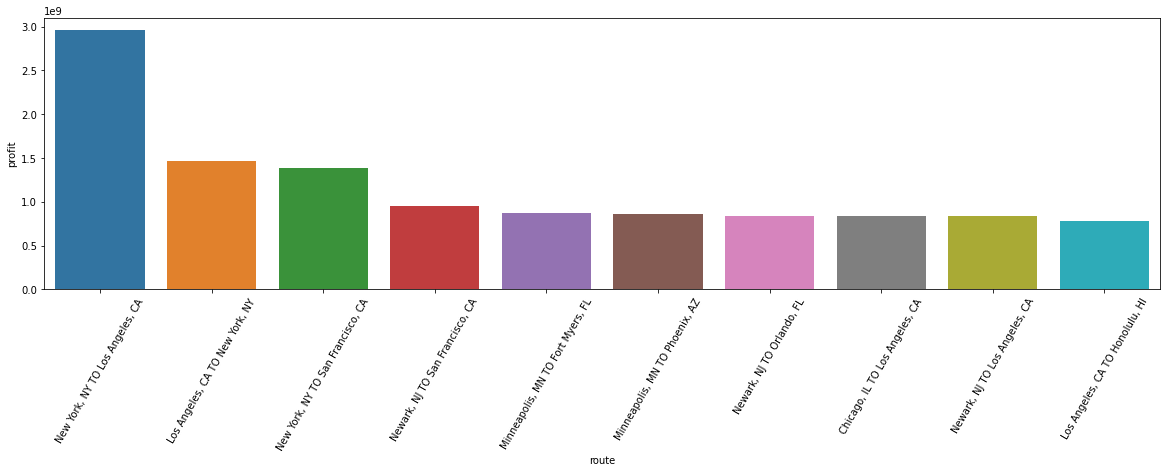

In [640]:
data['profit']=data['income']-data['cost']
temp=data.sort_values(by='profit',ascending=False)[:10]
ax=sns.barplot(x=temp['route'],y=temp['profit'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


## Total Profit generated by a route in 1 round trip .

[Text(0, 0, 'Pittsburgh, PA TO San Diego, CA'),
 Text(1, 0, 'Minneapolis, MN TO West Palm Beach/Palm Beach, FL'),
 Text(2, 0, 'Greer, SC TO Las Vegas, NV'),
 Text(3, 0, 'Columbus, OH TO Austin, TX'),
 Text(4, 0, 'Madison, WI TO Los Angeles, CA'),
 Text(5, 0, 'Raleigh/Durham, NC TO San Antonio, TX'),
 Text(6, 0, 'Greer, SC TO Orlando, FL'),
 Text(7, 0, 'Greer, SC TO San Francisco, CA'),
 Text(8, 0, 'Minneapolis, MN TO Fort Myers, FL'),
 Text(9, 0, 'Birmingham, AL TO San Francisco, CA')]

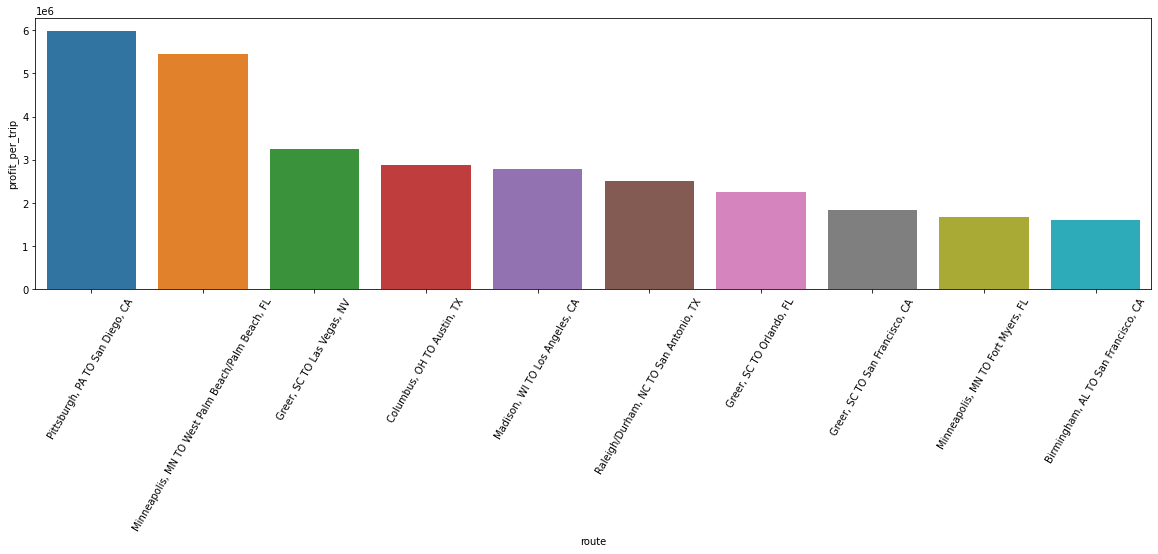

In [641]:
data['profit_per_trip']=data['profit']/data['total_count']
temp=data.sort_values(by='profit_per_trip',ascending=False)[:10]
ax=sns.barplot(x=temp['route'],y=temp['profit_per_trip'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


This shows a very vivid picture and hence let's see the total number of flights 

This does not show the right picture as there is not many flights in these routes. We want to gain on customers and revenue therefore we should take only the profit in busy airport. 

So let's now add one more column whether an airport is busy or not. 

## Making Busy Column

Calculating busy airports on the basis of our needs. 

**Method**
1) We have 5 planes to operate
2) The total_count of routes is for a quarter which is 3 months so approximate 90 days
3) Let's say a plane flies once everyday and is then under maintainance.
4) It gives us 90*5 =450. We could fly upto 450 times in a month and we need to make profit in that.  
5) Increasing the value by 20% because we don't know about seasonality. So we would consider all airports as busy, if we have above 600 total_count.


In [642]:
data['busy_route']=np.where((data['total_count']>=600),1,0)

## Total Profit generated by a route in 1 round trip in busy routes

[Text(0, 0, 'Minneapolis, MN TO Orlando, FL'),
 Text(1, 0, 'New York, NY TO Los Angeles, CA'),
 Text(2, 0, 'New York, NY TO Las Vegas, NV'),
 Text(3, 0, 'Newark, NJ TO San Francisco, CA'),
 Text(4, 0, 'Newark, NJ TO Los Angeles, CA'),
 Text(5, 0, 'Minneapolis, MN TO Phoenix, AZ'),
 Text(6, 0, 'Minneapolis, MN TO Las Vegas, NV'),
 Text(7, 0, 'New York, NY TO San Francisco, CA'),
 Text(8, 0, 'Detroit, MI TO Fort Lauderdale, FL'),
 Text(9, 0, 'Boston, MA TO Orlando, FL')]

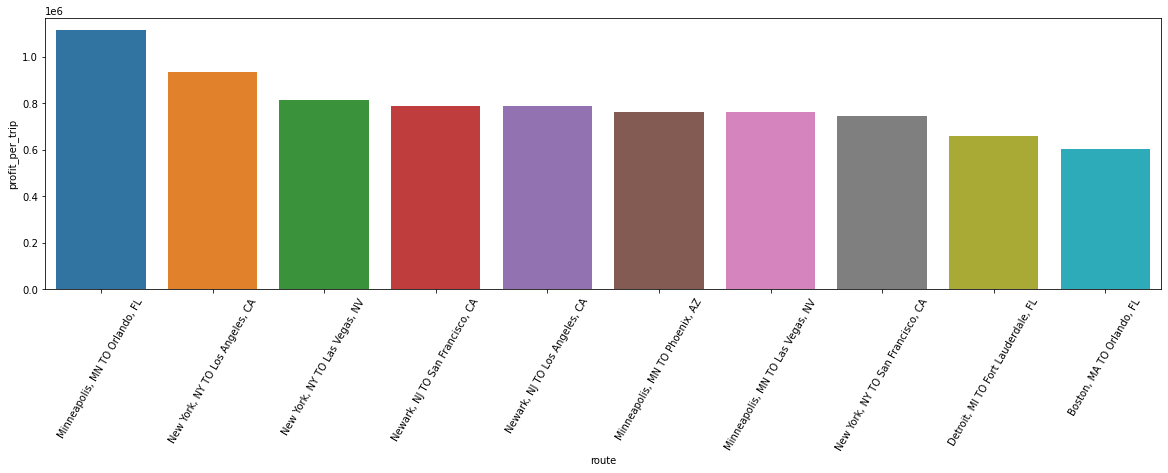

In [643]:
temp=data[data['busy_route']==1]
temp=temp.sort_values(by='profit_per_trip',ascending=False)[:10]
ax=sns.barplot(x=temp['route'],y=temp['profit_per_trip'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


## Top 10 Least Delay in busy routes

[Text(0, 0, 'Honolulu, HI TO Kona, HI'),
 Text(1, 0, 'Atlanta, GA TO Norfolk, VA'),
 Text(2, 0, 'Honolulu, HI TO Hilo, HI'),
 Text(3, 0, 'Salt Lake City, UT TO Portland, OR'),
 Text(4, 0, 'Honolulu, HI TO Lihue, HI'),
 Text(5, 0, 'Charleston, SC TO Atlanta, GA'),
 Text(6, 0, 'Boise, ID TO Portland, OR'),
 Text(7, 0, 'Atlanta, GA TO Greensboro/High Point, NC'),
 Text(8, 0, 'Atlanta, GA TO Salt Lake City, UT'),
 Text(9, 0, 'Portland, OR TO Boise, ID')]

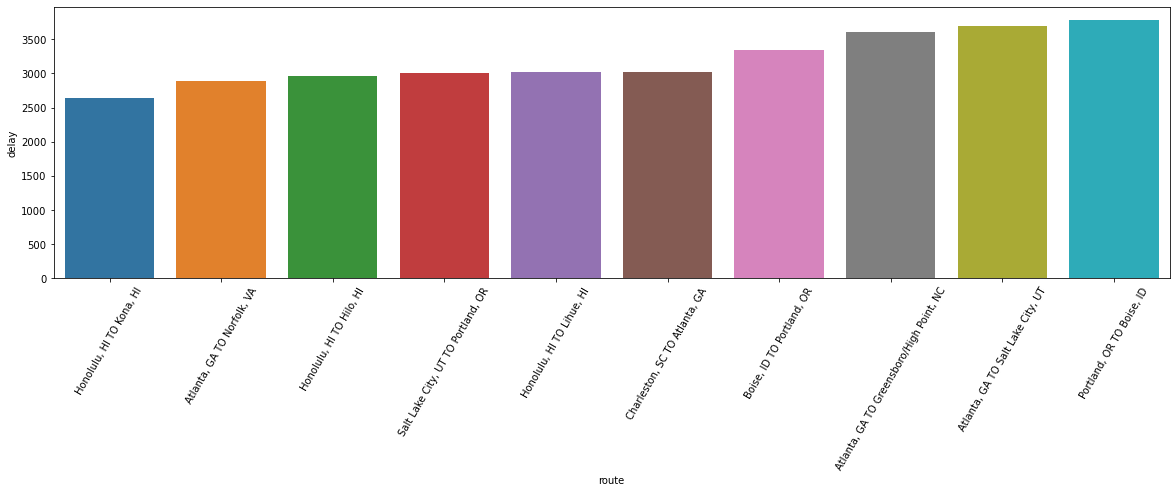

In [644]:
data['delay']=data['DEP_DELAY']+data['ARR_DELAY'] 
temp=data[data['busy_route']==1]
temp=temp.sort_values(by='delay',ascending=True)[:10]
ax=sns.barplot(x=temp['route'],y=temp['delay'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


## Our Major Goal is to 
1) Increase Profit
2) Increasing Customer Base
3) Making sure that there is minimum delay as our motto is "On time, for you"

### Building our Score metric

First we will be normalizing Profit, total Flights and Delay metric in between 0,1 and these will be our scores individually.

For profit and total_flights increasing scores means good scores but for delay it would be inverse. So after normalizing we would negate it by 1

Then defining our **score** metric.
It would be our weighted_average. We will have 40% weightage on delay and 30% on total_flights and 30% on profit. 

In [652]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
temp=data[data['busy_route']==1]
x_scaled = min_max_scaler.fit_transform(temp[['delay','profit_per_trip','total_count']])
temp['delay']=x_scaled[:,0].tolist()
temp['delay']=1-temp['delay']

temp['profit_per_trip']=x_scaled[:,1].tolist()
temp['total_count']=x_scaled[:,2].tolist()
temp['score']=0.33*temp['delay']+0.33*temp['profit_per_trip']+0.33*temp['total_count']

[Text(0, 0, 'New York, NY TO Los Angeles, CA'),
 Text(1, 0, 'Minneapolis, MN TO Orlando, FL'),
 Text(2, 0, 'New York, NY TO Las Vegas, NV'),
 Text(3, 0, 'Los Angeles, CA TO New York, NY'),
 Text(4, 0, 'Minneapolis, MN TO Phoenix, AZ'),
 Text(5, 0, 'Newark, NJ TO Los Angeles, CA'),
 Text(6, 0, 'New York, NY TO San Francisco, CA'),
 Text(7, 0, 'Minneapolis, MN TO Las Vegas, NV'),
 Text(8, 0, 'Newark, NJ TO San Francisco, CA'),
 Text(9, 0, 'Detroit, MI TO Orlando, FL')]

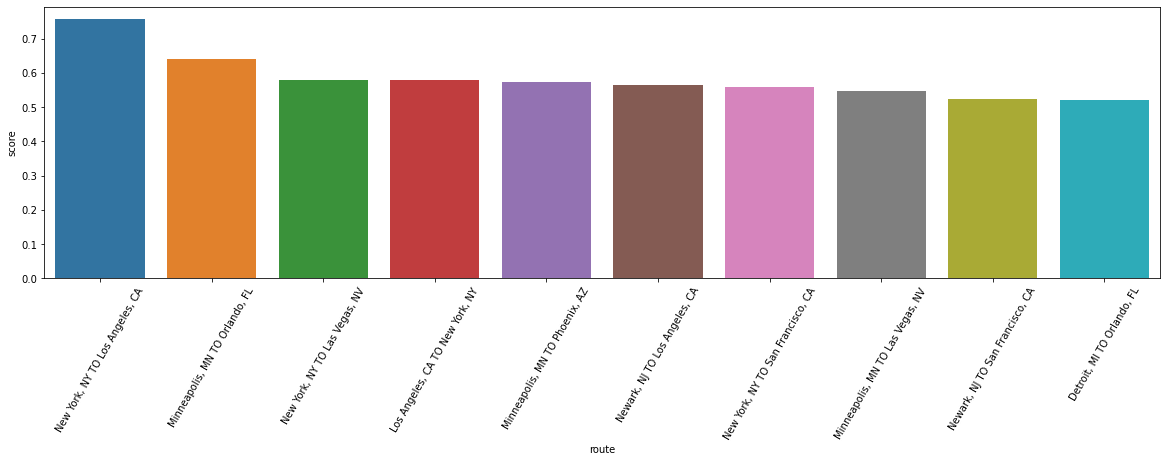

In [654]:
temp=temp.sort_values(by='score',ascending=False)[:10]
ax=sns.barplot(x=temp['route'],y=temp['score'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)


## Q3) The 5 round trip routes that you recommend to invest in based on any factors that you choose.

## My Top Choices would be 

 
1) New York,NY to Los Angeles,CA 
2) Minnepolis,MN to Orlando,FL 
3) New York,NY to Las Vegas,NV 
4) Los Angeles,CA to New York,CA 
5) Minnepolis,MN to Pheonix,AZ 

## Q4) The number of round trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.

**Route1    New York,NY to Los Angeles,CA**


**Route2    Minnepolis,MN to Orlando,FL**

**Route3    New York,NY to Las Vegas,NV**

**Route4    Los Angeles,CA to New York,CA**

**Route5    Minnepolis,MN to Pheonix,AZ**

The calculations are provided in the pdf document. 

## Q5) Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round trip routes that you recommend.

Essential KPI's which are already given are 

1) Distance
2) Fare
3) Arrival Delay
4) Departure Delay
5) Occupancy Rate

Others which could give us more info are

1) Distribution of Business and Economy level seats
2) Target audience for the airlines. The scoring metric will change according to that
3) Income distribution of the city. More income means more premium travel requirement
4) Promotion and discounted ticket information was not given. This can also help with the analysis
5) Busy airports. Some times load factor on airports are very high so therefore there could be more delays and such airports could be avoided. 6) Weather data . Places with good weather should be prioritized as there would be less last minute cancellations and preventing bad news for customers.  
7) Research on places should be carried out where government is supporting tourism or business.
8) Flight change information.  Customers are not happy when there are frequent flight changes as it affects there schedule.  
9) Income from Pantry inside the airlines should be mentioned. Indirect cost associated to that as well. It will help us know how is the profit or loss in long and short travel journey. 
